## Base de dados poluição_china
A base de dados pode ser encontrada [aqui](https://github.com/Gttz/Cursos-DataScience/blob/main/Deep%20Learning%20com%20Python%20de%20A%20a%20Z/Datasets/poluicao_china.csv)


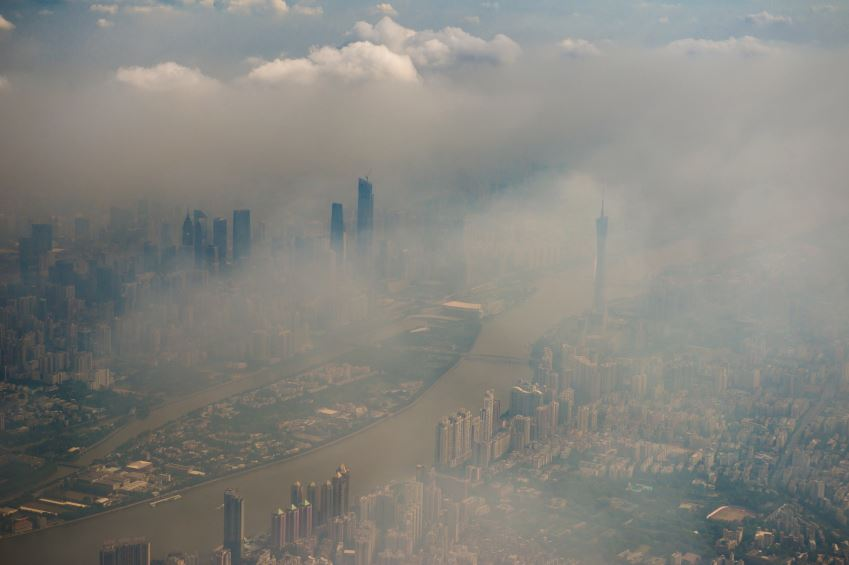

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('poluicao_china.csv')

In [3]:
df.head(3)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0


Temos 13 colunas presentes no dataset fornecido, sendo 7 delas variáveis características (dados de entrada) e uma delas uma variável-alvo (que queremos que o nosso modelo seja capaz de prever).

As colunas irrelevantes que serão apagadas são:

    No         - Contagem dos registros (irrelevante)
    year       - Ano (irrelevante)
    month      - Mês (irrelevante)
    hour       - Hora (irrelevante)
    cbwd       - Coluna irrelevante
    

A variável-alvo é:

    pm2.5      - Valor real

###### Apagando colunas irrelevantes:

In [4]:
df = df.drop(['No', 'year', 'month', 'day', 'hour', 'cbwd'], axis = 1)

###### Tratando os valores faltantes (NaN)

In [5]:
print("Valores nulos antes da transformação: \n\n{}\n".format(df.isnull().sum(axis = 0)))

Valores nulos antes da transformação: 

pm2.5    2067
DEWP        0
TEMP        0
PRES        0
Iws         0
Is          0
Ir          0
dtype: int64



In [6]:
df = df.dropna()

In [7]:
# Visualizando os dados faltantes do dataset após a terceira transformação
print("Valores nulos após a transformação: \n\n{}\n".format(df.isnull().sum(axis = 0)))

Valores nulos após a transformação: 

pm2.5    0
DEWP     0
TEMP     0
PRES     0
Iws      0
Is       0
Ir       0
dtype: int64



###### Definição das features do nosso modelo

In [8]:
df.shape

(41757, 7)

In [9]:
df.columns

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir'], dtype='object')

In [10]:
X= df.iloc[:, 1:7].values

In [11]:
y = df.iloc[:, 0].values

#### Normalização dos dados da base de treinamento
Podemos observar que os nossos dados estão em escalas diferentes das demais, principalmente da coluna 'PRES', para isso iremos utilizar a função ``MinMaxScaler`` para realizar a normalização dos dados.

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
normalizador = MinMaxScaler(feature_range = (0, 1))

In [14]:
X_normalizado = normalizador.fit_transform(X)

In [15]:
# Estava obtendo um erro ao tentar normalizar a váriavel-alvo, é preciso realizar um reshape
y = y.reshape(-1, 1)
y_normalizado = normalizador.fit_transform(y)

###### Coletando os valores das datas anteriores
Para realizar a previsão do dia de 'hoje' precisamos pegar o valor real das 90 previsões dos dias anteriores, para isso criaremos um vetor com as 90 primeiras linhas do dataset.

    array previsores - ele receberá as primeiras 90 linhas para o treinamento
    array poluicao_real - ele receberá todas as poluições da linha 100 até 41757

In [16]:
X_normalizado.shape

(41757, 6)

In [17]:
previsores = []
poluicao_real = []
# Criação da estrutura de dados que representa a série temporal (100 horas passadas para a realização da previsão da hora atual)
for i in range(100, 41757):
    previsores.append(X_normalizado[i-100:i, 0:6])
    poluicao_real.append(y_normalizado[i, 0])
# Conversão para o tipo 'Series' e adicionando-os
previsores, poluicao_real = np.array(previsores), np.array(poluicao_real)

#### Redes Neurais Recorrentes
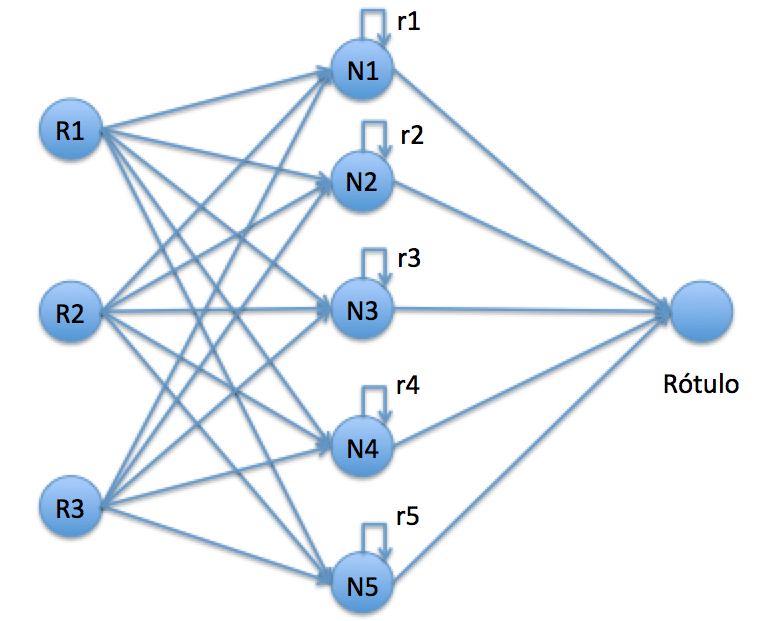

###### Importações
Para isso, utilizaremos a biblioteca ``keras``

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

###### Parâmetros da rede neural recorrente:
Link: https://keras.io/

    Sequential - Criação de uma nova rede neural
    units - Número de celulas de memória (ideal um valor maior para adicionar mais dimensionalidade ao decorrer do tempo)
    return_sequences - utilizado quando se tem 2 ou mais LSTM (onde passa a informação para as outras camadas subsequentes)
    input_shape - Configurações anteriores dos dados de entrada
    Dropout - é usado para diminuir a chance de overfitting (30% dos neurônios de entrada são zerados)
    
###### Parâmetros do otimizador

    optimizer - 'RMSPROP' bastante utilizado em redes neurais recorrentes
    loss - Função de perda (mean_squared_error pois é um problema de regressão)
    metrics - Métrica de avaliação (pode ser colocado mais de um)

In [19]:
regressor = Sequential()
# Camada de entrada
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 6)))
regressor.add(Dropout(0.3))
# Camada oculta 1
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Camada oculta 2
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Camada oculta 3
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.1))
# Camada de saída
regressor.add(Dense(units = 1, activation = 'linear'))
# Otimizações
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

###### Parâmetros callbacks
Link: https://keras.io/api/callbacks

###### Parâmetro 01 - EarlyStopping
Link: https://keras.io/api/callbacks/early_stopping/

Conjuntos de funções que podem ser aplicados em determinados estados do processo de treinamento.

Obs: O treinamento é parado quando uma função monitorada para de melhorar.

    monitor - Função a ser monitorada
    min_delta - Mudança minima que deve ser monitorada a ser considerada como melhoria
    patience - Número de épocas que deve ser seguido sem o resultado (caso passe desse número o treinamento é parado)

In [20]:
es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 15, verbose = 1)

###### Parâmetro 02 - ReduceLROnPlateau
https://keras.io/api/callbacks/reduce_lr_on_plateau/

Reduz a taxa de aprendizagem quando uma métrica para de melhorar

    monitor - Função a ser monitorada
    fator - fator pelo qual a taxa de aprendizagem será reduzida. new_lr = lr * factor.
    min_delta - Mudança minima que deve ser monitorada a ser considerada como melhoria
    patience - Número de épocas que deve ser seguido sem o resultado (caso passe desse número o treinamento é parado)

In [21]:
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)

###### Parâmetro 03 - ModelCheckPoint
https://keras.io/api/callbacks/model_checkpoint/

Esta classe é utilizada para a melhora dos resultados e ele salva o modelo a cada uma das épocas (passado como paramêtro)

    filepath - Caminho do arquivo a ser salvo
    monitor  - Função a ser monitorada
    save_best_only - Sempre salva o que obteve o melhor resultado

In [22]:
mcp = ModelCheckpoint(filepath = 'poluicao_china.h5', monitor = 'loss', save_best_only = True, verbose = 1)

###### Treinamento do modelo

In [23]:
regressor.fit(previsores, poluicao_real, epochs = 10, batch_size = 64)

Epoch 1/10
651/651 [==============================] - 223s 320ms/step - loss: 0.0081 - mean_absolute_error: 0.0652
Epoch 2/10
651/651 [==============================] - 191s 293ms/step - loss: 0.0054 - mean_absolute_error: 0.0520
Epoch 3/10
651/651 [==============================] - 182s 279ms/step - loss: 0.0048 - mean_absolute_error: 0.0489
Epoch 4/10
651/651 [==============================] - 182s 279ms/step - loss: 0.0045 - mean_absolute_error: 0.0467
Epoch 5/10
651/651 [==============================] - 183s 281ms/step - loss: 0.0043 - mean_absolute_error: 0.0456
Epoch 6/10
651/651 [==============================] - 183s 281ms/step - loss: 0.0040 - mean_absolute_error: 0.0438
Epoch 7/10
651/651 [==============================] - 183s 281ms/step - loss: 0.0040 - mean_absolute_error: 0.0437
Epoch 8/10
651/651 [==============================] - 181s 278ms/step - loss: 0.0037 - mean_absolute_error: 0.0417
Epoch 9/10
651/651 [==============================] - 177s 273ms/step - loss: 0.

Acabei colocando poucas épocas pelo alto tempo de treinamento

In [24]:
previsoes = regressor.predict(previsores)
previsoes = normalizador.inverse_transform(previsoes)

In [25]:
previsoes.mean()

107.856575

In [26]:
poluicao_real.mean()

0.09926807647140738

In [27]:
print(f'A diferença da média das previsões e da poluição real foi de: {poluicao_real.mean() - previsoes.mean()}.')

A diferença da média das previsões e da poluição real foi de: -107.75730693573563.


###### Observando em gráficos

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

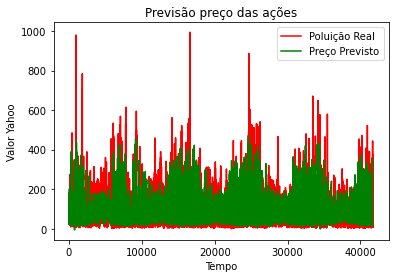

In [29]:
plt.plot(y, color = 'red', label = 'Poluição Real')
plt.plot(previsoes, color = 'green', label = 'Preço Previsto')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()